<a href="https://colab.research.google.com/github/tomonari-masada/course2021-nlp/blob/main/06_PyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch入門（2）
参考資料: 
* PyTorch公式のチュートリアル 
 * https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


* reproducibilityについては下記リンク先を参照
 * https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import random_split

torch.manual_seed(123)

## 1. 線形回帰
* 線形回帰モデルのミニバッチ学習をPyTorchで書いてみる。

### 人工的にデータを作る
 * $y = w_1 x_1 + w_2 x_2 + b + \epsilon$という式にしたがってデータを生成する。
  * $\epsilon$は正規分布に従うとする。 

In [ ]:
# データ数
DATA_SIZE = 1000

# ランダムな二次元ベクトルの集合を訓練データとして設定
X = 10 * torch.rand([DATA_SIZE, 2]) - 5.0

# 係数と切片（これに近い値が求まればよい）
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([10.0])

# y = w_1 x_1 + w_2 x_2 + b に正規乱数を加えた値がターゲット
y = X@w0 + b0 + torch.normal(0.0, 2.0, size=[DATA_SIZE, 1])

### 訓練データ、検証データ、テストデータへ分割
* train : dev : test = 8 : 1 : 1 に分割する。

In [ ]:
test_size = DATA_SIZE // 10
dev_size = test_size
train_dev_size = DATA_SIZE - test_size
train_size = train_dev_size - dev_size

train_dev_indices, test_indices = random_split(range(DATA_SIZE),
                                               [train_dev_size, test_size])
train_indices, dev_indices = random_split(train_dev_indices,
                                          [train_size, dev_size])

X_train, y_train = X[train_indices], y[train_indices]
X_dev, y_dev = X[dev_indices], y[dev_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [ ]:
print(X_train.shape, X_dev.shape, X_test.shape)

torch.Size([800, 2]) torch.Size([100, 2]) torch.Size([100, 2])


### 訓練データを可視化

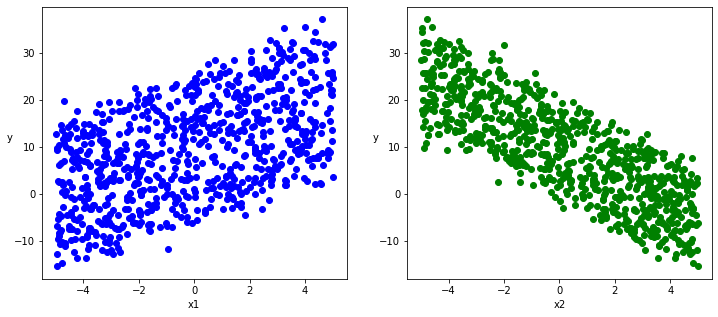

In [ ]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X_train[:, 0].numpy(), y_train[:, 0].numpy(), c="b")
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X_train[:, 1].numpy(), y_train[:, 0].numpy(), c="g")
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()

### TensorDatasetの利用
* 入力と出力のテンソルをペアを、最初の次元のインデックスで、取り出せる状態にする。
 * https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train, y_train)

In [ ]:
print(train_dataset[0])

(tensor([0.0585, 1.5224]), tensor([5.6471]))


### DataLoaderの利用
* 訓練データをシャッフルしてミニバッチをひとつずつ取り出す処理を、PyTorchのDataLoaderを使って実装する。
 * https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
from torch.utils.data import DataLoader

# ミニバッチのサイズ
BATCH_SIZE = 10

# 訓練データだけシャッフル
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(TensorDataset(X_dev, y_dev), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

In [ ]:
for b in test_loader:
  print(b)
  break

[tensor([[-3.6460, -1.1333],
        [ 2.9442,  3.9517],
        [ 3.1880,  0.7734],
        [-1.4366, -0.8235],
        [ 1.2026,  3.6804],
        [ 3.0857, -3.5130],
        [-2.7617, -1.9535],
        [ 4.2658, -4.6129],
        [ 4.2707, -2.1064],
        [ 4.8303, -1.1283]]), tensor([[ 3.6681],
        [ 4.2840],
        [10.9113],
        [ 6.7918],
        [ 4.0562],
        [28.0628],
        [11.9621],
        [29.4383],
        [22.2865],
        [25.3793]])]


### モデルの定義
* 値を推定したいのは、線形モデル$y = w_1 x_1 + w_2 x_2 + b$の係数$w_1,w_2$と切片$b$。
* そこで、係数と切片を微分可能なテンソルとして用意する。

In [ ]:
w = torch.randn((2, 1), requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [ ]:
print(w)
print(b)

tensor([[-0.2794],
        [ 0.6681]], requires_grad=True)
tensor([0.0766], requires_grad=True)


### 損失関数
* 平均二乗誤差を使う。
* PyTorchで用意されている損失関数については、下のリンク先を参照。
 * https://pytorch.org/docs/stable/nn.html#loss-functions

In [ ]:
criterion = torch.nn.MSELoss()

### optimizer
* SGDを使う。
* PyTorchで用意されているoptimizerについては、下のリンク先を参照。
 * https://pytorch.org/docs/stable/optim.html

In [ ]:
optimizer = torch.optim.SGD([w, b], lr=0.0001, momentum=0.9)

### 学習のループ
* ループのなかには、最低限、以下の４つを書く

1. gradientをゼロにする
2. 損失関数の値を計算することによって、計算グラフを作る
3. backpropagationの実行
4. パラメータの更新



In [ ]:
for epoch in range(30):

  train_loss = 0.0
  for input, target in train_loader:
    optimizer.zero_grad()
    # forward pass
    output = input @ w + b
    loss = criterion(output, target)
    train_loss += loss.item() * len(target) # 表示用の集計
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()

  # dev loss
  dev_loss = 0
  with torch.no_grad():
    for input, target in dev_loader:
      output = input @ w + b
      loss = criterion(output, target)
      dev_loss += loss.item() * len(target)

  # logging
  print(f'epoch {epoch + 1:4d} ;',
        f'train loss {train_loss / train_size:8.4f} ;',
        f'dev loss {dev_loss / dev_size:8.4f} ;',
        f'[{" ".join(["{:8.4f}".format(e.item()) for e in w])}]',
        f'{b.item():8.4f}')

epoch    1 ; train loss 152.4607 ; dev loss  81.9083 ; [  1.3637  -2.1103]   1.3384
epoch    2 ; train loss  71.3797 ; dev loss  53.3760 ; [  1.7787  -2.7555]   2.6147
epoch    3 ; train loss  51.4752 ; dev loss  38.5620 ; [  1.8592  -2.9235]   3.7257
epoch    4 ; train loss  38.3529 ; dev loss  28.1354 ; [  1.8978  -2.9384]   4.6738
epoch    5 ; train loss  28.9293 ; dev loss  20.8988 ; [  1.9076  -2.9447]   5.4742
epoch    6 ; train loss  22.1378 ; dev loss  15.6611 ; [  1.9521  -2.9905]   6.1584
epoch    7 ; train loss  17.2324 ; dev loss  12.0661 ; [  1.9445  -2.9771]   6.7373
epoch    8 ; train loss  13.6765 ; dev loss   9.5469 ; [  1.9466  -2.9933]   7.2316
epoch    9 ; train loss  11.1043 ; dev loss   7.7217 ; [  1.9773  -3.0048]   7.6494
epoch   10 ; train loss   9.2522 ; dev loss   6.4902 ; [  1.9818  -3.0037]   8.0047
epoch   11 ; train loss   7.9145 ; dev loss   5.6465 ; [  1.9846  -3.0126]   8.3134
epoch   12 ; train loss   6.9563 ; dev loss   5.0923 ; [  1.9807  -3.0182]  

## 2. TensorBoardによる可視化
* TensorBoardを使ってみる。
 * https://pytorch.org/docs/stable/tensorboard.html
* 上の線形回帰モデルの学習をもう一度そのままおこない、結果を可視化する。

### TensorBoardのnotebook extensionをロードしておく

In [ ]:
%load_ext tensorboard

### TensorBoardを使う準備
* PyTorchのSummaryWriterを使う。
* デフォルトの設定では、「runs」というディレクトリの下にイベント・ファイルが保存される。
* SummaryWriterのlog_dirというパラメータで、イベント・ファイルを保存するディレクトリを指定することもできる。

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

### モデルと損失関数と最適化アルゴリズムの準備
* （上ですでにおこなったことを、改めてもう一度書いているだけです。）

In [ ]:
w = torch.randn((2, 1), requires_grad=True)
b = torch.randn(1, requires_grad=True)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD([w, b], lr=0.0001, momentum=0.9)

### SummaryWriterを使って損失関数の値を記録する
* add_scalarメソッドを使っている。

In [ ]:
for epoch in range(30):

  train_loss = 0.0
  for input, target in train_loader:
    optimizer.zero_grad()
    # forward pass
    output = input @ w + b
    loss = criterion(output, target)
    train_loss += loss.item() * len(target)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
  writer.add_scalar('loss/training', train_loss / train_size, epoch)

  # dev loss
  dev_loss = 0
  with torch.no_grad():
    for input, target in dev_loader:
      output = input @ w + b
      loss = criterion(output, target)
      dev_loss += loss.item() * len(target)
  writer.add_scalar('loss/dev', dev_loss / dev_size, epoch)

### SummaryWriterを閉じる

In [ ]:
writer.close()

### 記録した損失関数の値をプロットする

In [ ]:
%tensorboard --logdir runs

## 3. nn.Sequentialのインスタンスとしてモデルを作る
* requires_grad=Trueでテンソルを作ればモデルを用意することはできる。
* しかし、同じことは、torch.nnを使えばもっとすっきり実現できる。
* まず、nn.Sequentialを使う方法を示す。

In [ ]:
import torch

torch.manual_seed(123)

### nn.Sequentialのインスタンスとしてモデルを作る
* 下記のようにモデルを作った時点でレイヤのパラメータは初期化されている。
* この初期化には上でセットした乱数のシードが使われている。

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 1)
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
type(model)

torch.nn.modules.container.Sequential

In [ ]:
# パラメータがどのように初期化されているかを確認してみる
for p in model.parameters():
  print(p.data)

tensor([[-0.2883,  0.0234]])
tensor([-0.3512])


* nn.Sequenceで作ったレイヤの重みを手動で初期化する方法については、下記のリンク先を参照。
 * https://discuss.pytorch.org/t/how-to-initialize-weights-in-nn-sequential-container/8534

### 損失関数とoptimizer
* optimizerにはモデルのパラメータを渡す。

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

### 学習のループ

In [ ]:
writer = SummaryWriter()

In [ ]:
for epoch in range(30):

  train_loss = 0.0
  for input, target in train_loader:
    optimizer.zero_grad()
    # forward pass
    output = model(input)
    loss = criterion(output, target)
    train_loss += loss.item() * len(target)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
  writer.add_scalar('loss/training', train_loss / train_size, epoch)

  # dev loss
  dev_loss = 0
  with torch.no_grad():
    for input, target in dev_loader:
      output = model(input)
      loss = criterion(output, target)
      dev_loss += loss.item() * len(target)
  writer.add_scalar('loss/dev', dev_loss / dev_size, epoch)

### モデルのグラフを表示させる
* SummaryWriterのadd_graphメソッドを使う。

In [ ]:
# 訓練データの最初のインスタンス（どのインスタンスでもよい）でグラフを作る

writer.add_graph(model, next(iter(train_loader))[0])

In [ ]:
writer.close()

In [ ]:
%tensorboard --logdir runs

## 4. nn.Moduleを継承してモデルを作る
* nn.Moduleを継承するクラスを定義する。
* そしてそのクラスのインスタンスとしてモデルを作る。

In [ ]:
class MyLinearModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size)
    self.init_weights() # これが無くても初期化されるが、初期化の方法を説明するため敢えて書いている

  def init_weights(self):
    self.fc.weight.data.normal_()
    self.fc.bias.data.normal_()

  def forward(self, input):
    return self.fc(input)

In [ ]:
model = MyLinearModel(2, 1)

In [ ]:
# パラメータがどのように初期化されているかを確認してみる
for p in model.parameters():
  print(p.data)

tensor([[ 0.6978, -1.3892]])
tensor([-0.3297])


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
writer = SummaryWriter()

In [ ]:
for epoch in range(30):

  train_loss = 0
  for input, target in train_loader:
    optimizer.zero_grad()
    # forward pass
    output = model(input)
    loss = criterion(output, target)
    train_loss += loss.item() * len(target)
    # backward pass
    loss.backward()
    # update parameters
    optimizer.step()
  writer.add_scalar('loss/training', train_loss / train_size, epoch)

  # dev loss
  dev_loss = 0
  with torch.no_grad():
    for input, target in dev_loader:
      output = model(input)
      loss = criterion(output, target)
      dev_loss += loss.item() * len(target)
  writer.add_scalar('loss/dev', dev_loss / dev_size, epoch)

In [ ]:
writer.add_graph(model, next(iter(train_loader))[0])

In [ ]:
writer.close()

In [ ]:
%tensorboard --logdir runs